<a href="https://colab.research.google.com/github/MaJinWoo/OpenSourceAI-Team-Project/blob/main/HeartFailurePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/Dataset

/content/gdrive/MyDrive/Dataset


In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import cv2
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
from tensorflow.keras.layers import BatchNormalization
import pickle
import os

In [6]:
data = pd.read_csv('heart.csv')

##Data shape & information

In [7]:
data.shape

(918, 12)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


##Visualize dataset

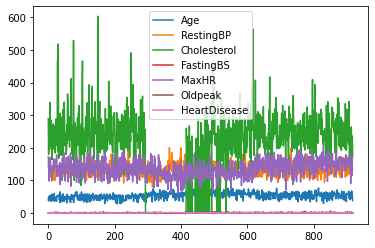

In [8]:
data.plot()
plt.show()

In [9]:
d2 = pd.DataFrame(data.groupby(['Sex', 'HeartDisease'])['Sex'].count())
d2

Sex
Sex HeartDisease     
F   0             143
    1              50
M   0             267
    1             458

In [8]:
X = data.iloc[:,: -1]
y = data.iloc[:, -1]

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [19]:
ct1 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1,2,6,8,10])], remainder='passthrough')


In [20]:
X = ct1.fit_transform(X)

In [21]:
X = pd.DataFrame(X)

In [22]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,40.0,140.0,289.0,0.0,172.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,49.0,160.0,180.0,0.0,156.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,37.0,130.0,283.0,0.0,98.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,48.0,138.0,214.0,0.0,108.0,1.5
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,54.0,150.0,195.0,0.0,122.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,45.0,110.0,264.0,0.0,132.0,1.2
914,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,68.0,144.0,193.0,1.0,141.0,3.4
915,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,57.0,130.0,131.0,0.0,115.0,1.2
916,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,57.0,130.0,236.0,0.0,174.0,0.0


RFE 함수 사용 예제
RFE는 모델 성능에 가장 도움이 되지 않는 1가지 feature씩 순서대로 제거하여

원하는 feature 개수인 n개가 남을때까지 수행하는 방법입니다.

 

따라서, 여기서는 고를 feature 개수인 n을 지정해야 하며,

n_features_to_select 인자에 지정해주시면 됩니다.

 

한 step마다 제거할 feature 개수도 step 인자에 지정이 가능합니다.

 

학습시킬 모델을 지정한 뒤, RFE로 feature selection을 진행하는 예시 코드는 다음과 같습니다.

(로지스틱 회귀 모델 및 10개의 feature 선별, 한 step에 1개씩 제거하는 상황을 가정했습니다.)

In [ ]:
from

##Split data into training and test set

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [25]:
X_train.shape

(734, 20)

In [26]:
X_test.shape

(184, 20)

In [27]:
model = Sequential()


model.add(Dense(units=20,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=60,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=30,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=1,activation='sigmoid'))


# For a binary classification problem
model.compile(loss='binary_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.001),metrics=[BinaryAccuracy()])

In [31]:
model.fit(X_train, y_train, epochs = 300, batch_size = 62, validation_data = (X_test, y_test))

Epoch 1/300
12/12 [==============================] - 0s 26ms/step - loss: 1.8422 - binary_accuracy: 0.5368 - val_loss: 0.7025 - val_binary_accuracy: 0.5924
Epoch 2/300
12/12 [==============================] - 0s 10ms/step - loss: 1.5919 - binary_accuracy: 0.5749 - val_loss: 0.6936 - val_binary_accuracy: 0.5815
Epoch 3/300
12/12 [==============================] - 0s 12ms/step - loss: 1.6292 - binary_accuracy: 0.5286 - val_loss: 0.6691 - val_binary_accuracy: 0.5924
Epoch 4/300
12/12 [==============================] - 0s 11ms/step - loss: 1.3641 - binary_accuracy: 0.5668 - val_loss: 0.6468 - val_binary_accuracy: 0.5707
Epoch 5/300
12/12 [==============================] - 0s 8ms/step - loss: 1.2304 - binary_accuracy: 0.5613 - val_loss: 0.6388 - val_binary_accuracy: 0.5761
Epoch 6/300
12/12 [==============================] - 0s 5ms/step - loss: 1.1550 - binary_accuracy: 0.5749 - val_loss: 0.6375 - val_binary_accuracy: 0.5598
Epoch 7/300
12/12 [==============================] - 0s 6ms/step -

In [32]:
model_loss = pd.DataFrame(model.history.history)


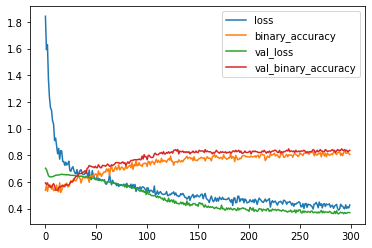

In [33]:
model_loss.plot()
